In [1]:
import cirq
import qsimcirq
import numpy as np
import qiskit
import qiskit_ibm_runtime
from qiskit_aer import AerSimulator
import stimcirq
import matplotlib.pyplot as plt

from qiskit.visualization import plot_histogram
from encoded.dj import dj, dj_repetition, dj_steane
from encoded.LST import int_to_binary

## Computer parameters

In [2]:
# Computer and qubits to use.
# Option 1: Use saved noise characteristics.
computer = qiskit_ibm_runtime.fake_provider.FakeKyiv()
#computer = AerSimulator()  # Noiseless simulator - use this for a sanity check to see all computed expectation
layout = {
    1 : [63, 64],
    3 : [65, 66, 67, 73, 84, 85],
    5 : [64, 65, 66, 67, 72,81, 82, 83, 84, 85],
    7 : [61, 62, 63, 64, 65, 66, 67, 72, 73, 81, 82, 83, 84, 85],
    #7 : [117,122,123, 124, 125, 126, 127,136,137,143,144,145,146,147]
}

## Oracle definition

In [3]:
total_qubits = 2
# Random case
# oracleType, oracleValue = np.random.randint(2), np.random.randint(2)
# if oracleType == 1:
#     oracleValue = np.random.randint(1, 2**(total_qubits-1))

# Fixed case
oracleType, oracleValue = 1, 2**(total_qubits-1)-1

oracleType,oracleValue

(1, 1)

## Full conectivity

### Analog version

In [4]:
n_shots = 1_000_000
noise = cirq.depolarize
simulator = stimcirq.StimSampler()
noise_set = np.logspace(-7,-3,10)
infidelity_analog = []
for noise_ratio in noise_set:
    qreg = cirq.LineQubit.range(total_qubits)
    circuit = dj(qreg,oracleType,oracleValue)
    circuit.append(cirq.measure(qreg[:total_qubits-1], key="m"))
    circuit = circuit.with_noise(noise(noise_ratio))
    counts = simulator.run(circuit, repetitions=n_shots).histogram(key="m")
    if oracleType==1:
        infidelity_analog.append(1-counts[int("1",2)]/n_shots)
    else:
        infidelity_analog.append(1-counts[int("0"*(total_qubits-1))]/n_shots)

### Repetition code version

In [5]:
oracleType, oracleValue = 1, 2**(total_qubits-1)-1
k = 2 
n_encoding = 3

logical_1_codeword = ["111"]
logical_0_codeword = ["000"]


infidelity_encoded = []
for noise_ratio in noise_set:
    qreg = cirq.LineQubit.range(n_encoding*k)
    circuit= dj_repetition(qreg,n_encoding,oracleType,oracleValue)
    circuit.append(cirq.measure(qreg[:n_encoding*(k-1)], key="m"))
    circuit = circuit.with_noise(noise(noise_ratio))
    counts = simulator.run(circuit, repetitions=n_shots).histogram(key="m")

    counts_logical_1 = 0
    for e in logical_1_codeword:
        counts_logical_1 += counts[int(e,2)]
    counts_logical_0 = 0
    for e in logical_0_codeword:
        counts_logical_0 += counts[int(e,2)]

    if oracleType==1 and oracleValue ==1:
        infidelity_encoded.append(1-counts_logical_1/(counts_logical_1+counts_logical_0))
    else:
        infidelity_encoded.append(1-counts_logical_0/(counts_logical_1+counts_logical_0))


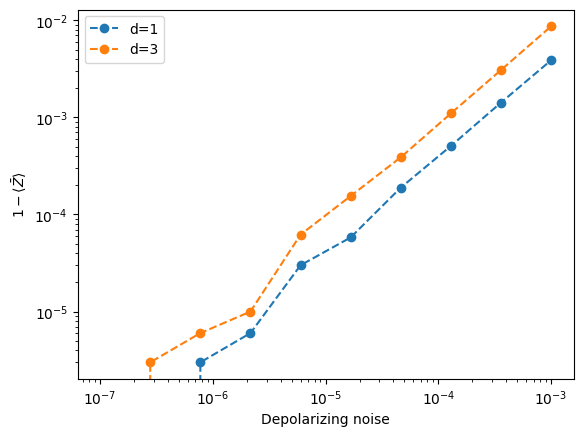

In [6]:
plt.figure()
plt.loglog(noise_set,infidelity_analog,"--o",label = "d=1")
plt.loglog(noise_set,infidelity_encoded,"--o",label = "d=3")


# plt.ylim(1e-4,5e-1)
plt.xlabel("Depolarizing noise")
plt.ylabel(r"$1-\langle \bar{Z} \rangle$")
plt.legend()


## Transpiled

We now transpile the circuit to a FakeIbm computer but use the cirq noise model

In [ ]:
def count_gates(qc: qiskit.QuantumCircuit):
    gate_count = {qubit: 0 for qubit in qc.qubits}
    for gate in qc.data:
        for qubit in gate.qubits:
            gate_count[qubit]+=1
    return gate_count

def remove_idle_qwires(qc: qiskit.QuantumCircuit):
    gate_count = count_gates(qc)
    for qubit,count in gate_count.items():
        if count==0:
            qc.qubits.remove(qubit)
    return qc

## Analog version

In [26]:
import qiskit_aer.noise as noise
n_shots = 500_000
qreg = cirq.LineQubit.range(total_qubits)
circuit = dj(qreg,oracleType,oracleValue)
circuit.append(cirq.measure(qreg[:total_qubits-1], key="m"))
circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())
computer = qiskit_ibm_runtime.fake_provider.FakeKyiv()

compiled_raw = qiskit.transpile(
    circuit, 
    backend=computer,
    initial_layout=layout[1],  
    routing_method="sabre",
    optimization_level=0,
)


job = computer.run(compiled_raw, shots=n_shots)
counts = job.result().get_counts()

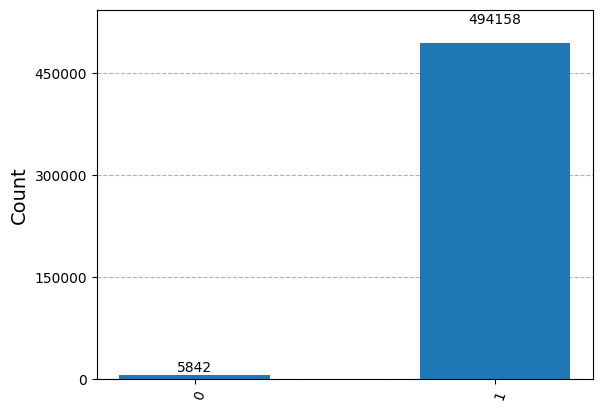

In [27]:
threshold = int(0.001 * n_shots) 
filteredAnswer = {k: v for k,v in counts.items() if v >= threshold}
removedCounts = np.sum([ v for k,v in counts.items() if v < threshold ]) 
plot_histogram(filteredAnswer)

In [28]:
100*counts["1"]/(counts["0"]+counts["1"])

98.8316

In [29]:
if oracleType==1:
    print("Total fidelity F = ",counts[int_to_binary(total_qubits-1,oracleValue)]/n_shots*100,"%")
else:
    print("Total fidelity F = ",counts["0"*(total_qubits-1)]/n_shots*100,"%")

Total fidelity F =  98.8316 %


## Encoding the repetition code (k = 2)

In [ ]:
oracleType, oracleValue = 1, 2**(total_qubits-1)-1
k = 2 
n_encoding = 3

logical_1_codeword = ["1"*n_encoding*(k-1)]
logical_0_codeword = ["0"*n_encoding*(k-1)]

qreg = cirq.LineQubit.range(n_encoding*k)
circuit= dj_repetition(qreg,n_encoding,oracleType,oracleValue)

circuit.append(cirq.measure(qreg[:n_encoding*(k-1)], key="m"))
circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())


compiled_raw = qiskit.transpile(
    circuit, 
    backend=computer,
    initial_layout=layout[n_encoding],
    routing_method="sabre", 
    optimization_level=3,
)
compiled_raw.count_ops()


job = computer.run(compiled_raw, shots=n_shots)
counts = job.result().get_counts()

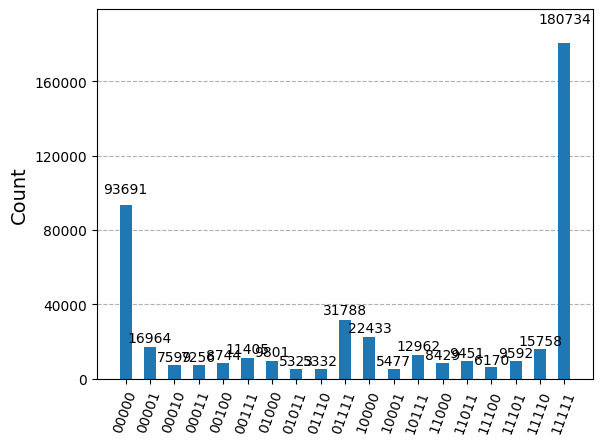

In [16]:
threshold = int(0.01 * n_shots)
filteredAnswer = {k: v for k,v in counts.items() if v >= threshold} 
removedCounts = np.sum([ v for k,v in counts.items() if v < threshold ]) 
plot_histogram(filteredAnswer)

### Using the encoding to take into account only the logical errors

In [17]:
counts_logical_1 = 0
for e in logical_1_codeword:
    counts_logical_1 += counts[e]
counts_logical_0 = 0
for e in logical_0_codeword:
    counts_logical_0 += counts[e]

if oracleType==1 and oracleValue ==1:
    print("Total fidelity F = ",counts_logical_1/(counts_logical_1+counts_logical_0)*100,"%")
else:
    print("Total fidelity F = ",counts_logical_0/(counts_logical_1+counts_logical_0)*100,"%")

Total fidelity F =  65.8591600619477 %
